In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams["figure.dpi"] = 300
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler

In [2]:
from sklearn.datasets import load_files

reviews_train = load_files("../data/aclImdb/train/")
# load_files returns a bunch, containing training texts and training labels
text_train, y_train = reviews_train.data, reviews_train.target
print("type of text_train: {}".format(type(text_train)))
print("length of text_train: {}".format(len(text_train)))
print("text_train[1]:\n{}".format(text_train[1].decode()))
text_train = [doc.replace(b"<br />", b" ") for doc in text_train]

type of text_train: <class 'list'>
length of text_train: 25000
text_train[1]:
Words can't describe how bad this movie is. I can't explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clichés, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won't list them here, but just mention the coloring of the plane. They didn't even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should with

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

text_train_sub, text_val, y_train_sub, y_val = train_test_split(
    text_train, y_train, stratify=y_train, random_state=0)
vect = CountVectorizer(min_df=2)
X_train = vect.fit_transform(text_train_sub)
X_val = vect.transform(text_val)

In [4]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=.1).fit(X_train, y_train_sub)

In [5]:
lr.score(X_val, y_val)

0.88095999999999997

# Gensim

In [6]:
docs = ["What is my purpose", "You bring butter"]
texts = [[token for token in doc.lower().split()] for doc in docs]
print(texts)

[['what', 'is', 'my', 'purpose'], ['you', 'bring', 'butter']]


In [7]:
from gensim import corpora
dictionary = corpora.Dictionary(texts)
print(dictionary)

Dictionary(7 unique tokens: ['is', 'my', 'purpose', 'what', 'bring']...)


In [8]:
new_doc = "what butter"
dictionary.doc2bow(new_doc.lower().split())

[(3, 1), (5, 1)]

In [9]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpus

[[(0, 1), (1, 1), (2, 1), (3, 1)], [(4, 1), (5, 1), (6, 1)]]

In [10]:
import gensim
corpus

[[(0, 1), (1, 1), (2, 1), (3, 1)], [(4, 1), (5, 1), (6, 1)]]

In [11]:
gensim.matutils.corpus2csc(corpus)

<7x2 sparse matrix of type '<class 'numpy.float64'>'
	with 7 stored elements in Compressed Sparse Column format>

In [12]:
X = CountVectorizer().fit_transform(docs)
X

<2x7 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [13]:
sparse_corpus = gensim.matutils.Sparse2Corpus(X.T)
print(sparse_corpus)
print(list(sparse_corpus))

[[(4, 1), (3, 1), (2, 1), (5, 1)], [(1, 1), (0, 1), (6, 1)]]


# Corpus transformations with gensim

In [14]:
tfidf = gensim.models.TfidfModel(corpus)
tfidf[corpus[0]]

[(0, 0.5), (1, 0.5), (2, 0.5), (3, 0.5)]

In [15]:
print(tfidf[corpus])
print(list(tfidf[corpus]))

[[(0, 0.5), (1, 0.5), (2, 0.5), (3, 0.5)], [(4, 0.57735026918962584), (5, 0.57735026918962584), (6, 0.57735026918962584)]]


# Word2Vec with gensim

In [16]:
from gensim import models
w = models.KeyedVectors.load_word2vec_format(
    '../../GoogleNews-vectors-negative300.bin', binary=True)

In [17]:
w['queen'].shape

(300,)

In [20]:
w.vectors.shape

(3000000, 300)

In [24]:
w.most_similar(positive=['movie'], topn=5)

[('film', 0.8676770925521851),
 ('movies', 0.8013108968734741),
 ('films', 0.7363011837005615),
 ('moive', 0.6830361485481262),
 ('Movie', 0.6693680286407471)]

In [31]:
w.most_similar(positive=['good'], topn=5)

[('great', 0.7291510105133057),
 ('bad', 0.7190051078796387),
 ('terrific', 0.6889115571975708),
 ('decent', 0.6837348341941833),
 ('nice', 0.6836092472076416)]

In [27]:
w.most_similar(positive=['cute', 'dog'], topn=5)

[('puppy', 0.7645270228385925),
 ('chihuahua', 0.7209305763244629),
 ('adorable_puppy', 0.7108923196792603),
 ('yorkie', 0.7013816833496094),
 ('Shitzu', 0.7004074454307556)]

In [22]:
print(text_train_sub[0].decode())

Maybe it's just because I have an intense fear of hospitals and medical stuff, but this one got under my skin (pardon the pun). This piece is brave, not afraid to go over the top and as satisfying as they come in terms of revenge movies. Not only did I find myself feeling lots of hatred for the screwer and lots of sympathy towards the "screwee", I felt myself cringe and feel pangs of disgust at certain junctures which is really a rare and delightful thing for a somewhat jaded horror viewer like myself. Some parts are very reminiscant of "Hellraiser", but come off as tribute rather than imitation. It's a heavy handed piece that does not offer the viewer much to consider, but I enjoy being assaulted by a film once and awhile. This piece brings it and doesn't appologize. I liked this one a lot. Do NOT watch whilst eating pudding.


In [33]:
vect_w2v = CountVectorizer(vocabulary=w.index2word)
vect_w2v.fit(text_train_sub)
docs = vect_w2v.inverse_transform(vect_w2v.transform(text_train_sub))
docs[0]

array(['in', 'for', 'that', 'is', 'the', 'at', 'not', 'as', 'it', 'by',
       'are', 'have', 'an', 'this', 'they', 'but', 'one', 'which', 'do',
       'than', 'over', 'just', 'some', 'like', 'only', 'did', 'because',
       'off', 'being', 'my', 'very', 'much', 'go', 'under', 'does', 'got',
       'top', 'come', 'really', 'lot', 'find', 'thing', 'once', 'offer',
       'feel', 'film', 'medical', 'terms', 'rather', 'certain', 'felt',
       'consider', 'watch', 'parts', 'heavy', 'towards', 'enjoy',
       'feeling', 'maybe', 'piece', 'fear', 'myself', 'stuff', 'handed',
       'brings', 'movies', 'hospitals', 'rare', 'lots', 'skin', 'eating',
       'intense', 'somewhat', 'liked', 'afraid', 'tribute', 'horror',
       'revenge', 'brave', 'whilst', 'sympathy', 'assaulted', 'satisfying',
       'hatred', 'viewer', 'awhile', 'pardon', 'delightful', 'disgust',
       'imitation', 'pudding', 'cringe', 'jaded', 'pun', 'pangs', 'doesn',
       'junctures', 'hellraiser', 'appologize'], 
      

In [34]:
X_train = np.vstack([np.mean(w[doc], axis=0) for doc in docs])

In [35]:
X_train.shape

(18750, 300)

In [36]:
docs_val = vect_w2v.inverse_transform(vect_w2v.transform(text_val))
X_val = np.vstack([np.mean(w[doc], axis=0) for doc in docs_val])

In [37]:
lr_w2v = LogisticRegression(C=100).fit(X_train, y_train_sub)
lr_w2v.score(X_train, y_train_sub)

0.86762666666666666

In [38]:
lr_w2v.score(X_val, y_val)

0.85711999999999999

# Semantic Arithmetic

In [39]:
w.most_similar(positive=['woman', 'king'], negative=['man'], topn=3)

[('queen', 0.7118192911148071),
 ('monarch', 0.6189674139022827),
 ('princess', 0.5902431607246399)]

In [40]:
w.most_similar(positive=['woman', 'he'], negative=['man'], topn=3)

[('she', 0.8492251634597778),
 ('She', 0.6329933404922485),
 ('her', 0.6029669046401978)]

In [41]:
w.most_similar(positive=['Germany', 'pizza'], negative=['Italy'], topn=3)

[('bratwurst', 0.5436394810676575),
 ('Domino_pizza', 0.5133179426193237),
 ('donuts', 0.5121968984603882)]

# Doc2Vec with gensim
Also see https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-lee.ipynb

In [42]:
def read_corpus(text, tokens_only=False):
    for i, line in enumerate(text):
        if tokens_only:
            yield gensim.utils.simple_preprocess(line)
        else:
            # For training data, add tags
            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(line), [i])


In [43]:
train_corpus = list(read_corpus(text_train_sub))
test_corpus = list(read_corpus(text_val, tokens_only=True))

In [51]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=50, min_count=2)
model.build_vocab(train_corpus)

In [57]:
model.train(train_corpus, total_examples=model.corpus_count, epochs=55)

In [58]:
import pickle
with open("doc2vec_50.pickle", "wb") as f:
    pickle.dump(model, f, -1)

In [56]:
import pickle
#with open("doc2vec.pickle", "rb") as f:
#    model = pickle.load(f)

AttributeError: Can't get attribute 'DocvecsArray' on <module 'gensim.models.doc2vec' from '/home/andy/anaconda3/lib/python3.6/site-packages/gensim/models/doc2vec.py'>

In [72]:
model.wv.most_similar("movie")

[('film', 0.9482318758964539),
 ('flick', 0.822228193283081),
 ('series', 0.715380072593689),
 ('programme', 0.7032747268676758),
 ('sequel', 0.6939107179641724),
 ('story', 0.6771408319473267),
 ('show', 0.6559576392173767),
 ('documentary', 0.6537493467330933),
 ('picture', 0.6427854299545288),
 ('thriller', 0.6300673484802246)]

In [59]:
vectors = [model.infer_vector(train_corpus[doc_id].words)
          for doc_id in range(len(train_corpus))]    

In [60]:
X_train = np.vstack(vectors)

In [61]:
X_train.shape

(18750, 50)

In [62]:
test_vectors = [model.infer_vector(test_corpus[doc_id])
                for doc_id in range(len(test_corpus))]   

In [75]:
text_val[1]

b'I enjoyed this film. It was funny, cute, silly, and entertaining. Had a fine cast and really got hammered by some critics for reasons that I truly don\'t understand. No, it wasn\'t "The Grapes of Wrath" or "Casablanca" or even "Moonstruck", but it was an enjoyable film.  Julia was excellent playing the psychotic \'man behind the man\'. The story is a little silly to be sure, but it this isn\'t high drama, folks. I happened to see a review of the film, probably the only good one it got and then ran into it one night when looking for a movie. I never heard it was supposed to stink until after I saw it, and I\'m glad I saw it. Eventually bought the VHS tape on the bargain pile, and I watch it a couple times a year.'

In [63]:
X_val = np.vstack(test_vectors)

In [81]:
from sklearn.metrics.pairwise import cosine_similarity
dist = cosine_similarity(X_train, X_val[1:2])

In [82]:
np.argmax(dist)

8026

In [83]:
text_train_sub[np.argmax(dist)]

b'I rented this movie because I was browsing through the horror movie section for those movies that no one\'s heard of and could be a possible gem. I saw this and, since I\'m a fan of violence and gore, I got it. It got the rating of EM which means: Extremely Mature. Thinking that this rare and high rating was totally meant for violence and everything else, I got it. The warning on the box said: Extreme Violence, Extreme Langauge, and Nudity. The "extreme violence" struck my fancy. The movie ended being a pretty tame slasher flick. It had one or two gory scenes but I\'ve seen worse in a PG-13 movie. Of course the amount of gore in a movie isn\'t all that counts, right? You have plot also. Well, the plot was boring and there nothing really special about it. Don\'t rent it. I speak the truth. I can\'t imagine how someone could really enjoy it to the point where they say: "I\'m gonna rent that again." It had it\'s moments where it kept you going but I\'m never going to see that film again

In [64]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=100).fit(X_train, y_train_sub)

In [65]:
lr.score(X_train, y_train_sub)

0.82826666666666671

In [66]:
lr.score(X_val, y_val)

0.81567999999999996

In [67]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=500, max_depth=8).fit(X_train, y_train_sub)
rf.score(X_train, y_train_sub)

0.86885333333333337

# Gradient Descent on Branin function

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def branin(x):
    x1 = x[0]
    x2 = x[1]
    a = 1.
    b = 5.1 / (4.*np.pi**2)
    c = 5. / np.pi
    r = 6.
    s = 10.
    t = 1. / (8.*np.pi)
    ret  = a*(x2-b*x1**2+c*x1-r)**2+s*(1-t)*np.cos(x1)+s
    return ret

def branin_derivative(x):
    x1 = x[0]
    x2 = x[1]
    a = 1.
    b = 5.1 / (4.*np.pi**2)
    c = 5. / np.pi
    r = 6.
    s = 10.
    t = 1. / (8.*np.pi)
    # d  = a*(x2-b*x1**2+c*x1-r)**2 + s*(1-t)*np.cos(x1)+s
    d1 = (-2*b*x1 + c)*a*2*(x2-b*x1**2+c*x1-r) - s*(1-t)*np.sin(x1)
    d2 = 2 * a * (x2-b*x1**2+c*x1-r)
    return d1, d2
    

range_x = np.linspace(-5, 10, 100)
range_y = np.linspace(0, 15, 100)
xx, yy = np.meshgrid(range_x, range_y)
res = np.array([branin(x) for x in zip(xx.ravel(), yy.ravel())])
res = res.reshape(xx.shape)

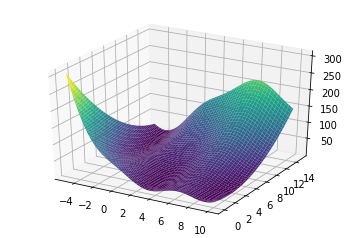

In [2]:
from mpl_toolkits.mplot3d import Axes3D
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))

surf = ax.plot_surface(xx, yy, res, cmap="viridis",
                       linewidth=0)
plt.show()


[ 5.85922718 13.24830687]
166.09719435114545
[3.13570383 2.30924523]
0.3989328706117341
[5.18430522 2.3455426 ]
15.629620442619814


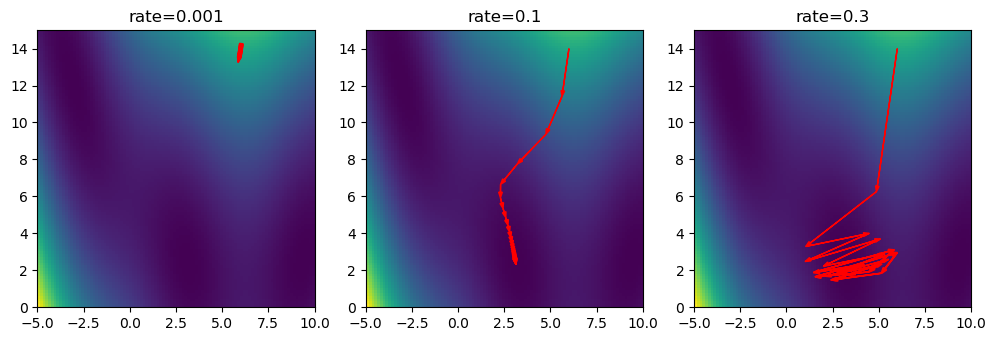

In [3]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5), dpi=100)
for ax, rate in zip(axes, [0.001, 0.1, 0.3]):
    ax.set_title("rate={}".format(rate))
    ax.imshow(res, origin="lower", extent=(range_x[0], range_x[-1], range_y[0], range_y[-1]))
    x = np.array((6, 14))
    for i in range(30):
        step = -rate * np.array(branin_derivative(x))
        ax.arrow(x[0], x[1], step[0], step[1], color='r', head_width=0.2, length_includes_head=True)
        x = x + step
    print(x)
    print(branin(x))
plt.tight_layout()

[2.85754784 3.7740132 ]
2.3881263551529903


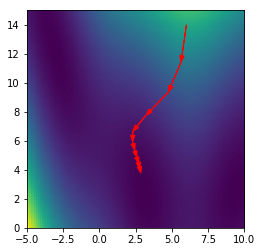

In [4]:
plt.figure()
plt.imshow(res, origin="lower", extent=(range_x[0], range_x[-1], range_y[0], range_y[-1]))
x = np.array((6, 14))
for i in range(10):
    grad = -0.1 * np.array(branin_derivative(x))
    plt.arrow(x[0], x[1], grad[0], grad[1], color='r', head_width=0.3, length_includes_head=True)
    x = x + grad
print(x)
print(branin(x))

In [5]:
from sklearn.linear_model import SGDClassifier
SGDClassifier()

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [8]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
iris = load_iris()

lda = LinearDiscriminantAnalysis()
np.mean(cross_val_score(lda, iris.data, iris.target, cv=10))

0.9800000000000001

In [11]:
from sklearn.utils import gen_batches, shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale

X_train, X_test, y_train, y_test = train_test_split(scale(iris.data),
                                                    iris.target, stratify=iris.target)
batches = [(X_train[batch], y_train[batch]) for batch in gen_batches(X_train.shape[0], 5)]

sgd = SGDClassifier()
for X_batch, y_batch in batches:
    sgd.partial_fit(X_batch, y_batch, classes=[0, 1, 2])
sgd.score(X_test, y_test)

/home/andy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.868421052631579

In [12]:
sgd = SGDClassifier()
for i in range(10):
    for X_batch, y_batch in batches:
        sgd.partial_fit(X_batch, y_batch, classes=[0, 1, 2])
sgd.score(X_test, y_test)

/home/andy/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


0.9210526315789473